# Explainer Notebook for Active Learning Simulation.

### Simulation Explanation
This is the explainer notebook for our Active Learning Simulation.

In essence, it is the notebook-version of the script ```active_learning_simulation.py``` found in this repository, and includes all the code of the script as well as additional explanations and walkthroughs in markdown (although the script-version is also well-documented). The purpose of the script-version is to serve as the primary development script, which can be run on the HPC, whilst the notebook-version is mandated by the assignment and also provides additional context and explanations of our simulation structure. The code between both is identical though, and so behave in the same way given the same preset configurations.

We have constructed a simulation, which can compare performance of various active learning algorithms against a random sampling baseline. Each algorithm is tested under different budget scenarios. 

Think of a budget scenario as having three key components: 
- How much labeled data we start with ($L_0$), with the remainder being the unlabeled pool ($U_0$) 
- How many new labeled samples we request in each round ($Q$) 
- How many rounds of requesting new data we perform ($T$) 

After each active learning query, we retrain and evaluate the model with the expanded dataset, which quickly increases the computational runtime of the simulation.

We designed four distinct budget scenarios, each representing an order of magnitude difference in the total annotation budget compared to our full dataset size. They are non-overlapping, meaning the final size of a budget strategy is lower than the initial size of the next strategy. 

To ensure robust results, each process can be run multiple times with different random initialization seeds, from which the performance on each AL algorithm on each budget strategy can be averaged. For context, a model trained on the full dataset can also be enabled to establish a performance ceiling.

The randomization seeds, AL algorithms and budget strategies to run, as well as model hyperparamters, dataset parameters, simulation parameters (such as saving) and more can all be set in the configuration cell to enable maximum simulation configurability.

### Results
For our final results, we ran 5 different seed runs of the first three budget strategies for all 7 active learning algorithms. Each iteration a model was trained for 8 epochs on data batch sizes of 32. The dataset was CIFAR-10 with balanced classes and a 80%/20% training/validation split, and we used ResNet-18 as our model with pretrained weights enabled. The results were saved, and a visualization of all the 7 AL algorithms (seed averaged) performance on each of the budget strategies is visualized in both our report and our poster. The full simulation was executed on the DTU HPC, and took 18 hours to complete.

Because of the substantial computational effort of this config, this notebook has a much smaller config set, which can be run without the use of the HPC within a "somewhat reasonable" timeframe.
This config only runs two of the same seeds of the final config, only the first two budget strategies, and only random sampling and uncertainty active learning sampling. It also trains a maximum performance ceiling model for each seed. All other parameters are maintained between the simplified and full simulation config.

Given the random initialization, the overlapping config runs that appear in both the simplified and full simulation config will have identical results, showing the consistency of the simulation structure. If you would like, the full simulation config can be re-run to get the exact same results as well.

The simplified config has been executed in full in this notebook, and can be followed by reviewing the print statements and plots.

### Simulation Code

Now, we proceed to the actual code of the simulation.

The below cell simply imports the necessary libraries and functions.

The custom functions are defined in three other scripts found in this repository:
- ```util_functions.py``` contains all functions related to the simulation, including randomization generators, model training and evaluation functions, dataset functions and other
- ```al_algorithms.py``` is only imported within the above utility functions script, but contains the code for all of the active learning algorithms that are testable in this simulation.
- ```analysis_functions.py``` contains some of the visualization functions for interpreting the results of the simulation

In [1]:
import os
import json
import torch
from torch.utils.data import random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
from util_functions import set_global_seed, full_training_set_baseline, active_learning_loop, format_time, create_imbalanced_cifar10
from analysis_functions import plot_al_performance_across_seeds
import numpy as np
from torch.utils.data import Subset

In the below cell, all the configuration parameters of the simulation can be set.

These includes:
- Dataset & Model:
  - What dataset to run
  - If the balanced dataset class distribution should be transformed to be unbalanced
  - What model to run
- Simulation parameters: If to save the results, and what relative folder to save them to
- Model hyperparameters, including:
  - If pretrained weights are enabled
  - Training/Validation split ratio
  - Number of epochs to train each model iteration on
  - The batch size of dataloaders
- Seed and baseline paramters: Randomization seeds to run and whether to train a maximum performance model for each seed
- Active learning algorithms to run
- Budget strategies to run, including:
  - Which ones to run
  - Initial size of dataset
  - Query size (for an iteration)
  - Number of iterations to run
- And finally, base ratios, which are used only for when the imbalanced dataset paramter is enabled.

The randomization is controlled by the seed, so identical config runs will produce identical results.

In [2]:
### Begin of Parameters ###

## Dataset & Model Parameters ##
dataset_name = "CIFAR-10" # "CIFAR-10" or "MNIST"
imbalanced_dataset = False # Enable to create an imbalanced dataset (only for CIFAR-10)
model_name = "ResNet-18" # Model to use for the simulation (only ResNet-18 supported)

## Simulation Parameters ##
save_results = True # Enable to save results to file
relative_save_folder = "./run_results" # Define relative save folder

## Model Hyperparameters ##
pretrained_weights = True # Enable to use pretrained weights for the model
TRAIN_VAL_RATIO = 0.8 # Ratio of training data to use for training (remaining is used for validation)
EPOCHS = 8 # Number of epochs to train the model for each budget size
BATCH_SIZE = 32 # Batch size for data loaders

## Seed and Baseline Parameters ##
seeds = [0, 1] # Set random seeds to decrease uncertainty
train_full_dataset_baseline = True # Enable to run the model with all labelled data to establish maximum performance baseline

## Active Learning Algorithm Parameters ##
AL_ALGORITHMS = {
    'random': {"active": True},
    'uncertainty': {"active": True},
    'typiclust': {"active": False},
    'margin': {"active": False}, 
    'entropy': {"active": False},
    'badge': {"active": False},
    'coreset': {"active": False},
}

## Budget Strategy Parameters ##
BUDGET_STRATEGIES = {
    1: {"active": True, "initial_size": 1000, "query_size": 250, "num_al_iterations": 10}, # Final size: 3500
    2: {"active": True, "initial_size": 4000, "query_size": 500, "num_al_iterations": 10}, # Final size: 9000
    3: {"active": False, "initial_size": 10000, "query_size": 1000, "num_al_iterations": 10}, # Final size: 20000
    4: {"active": False, "initial_size": 22000, "query_size": 2000, "num_al_iterations": 10}, # Final size: 42000 (almost full training/validation set size of 50000)
}

# Mimic real-world frequency distribution for CIFAR-10 classes (if enabled)
base_ratios = {
    0: 1.0,    # common classes
    1: 1.0,
    2: 0.7,    # moderately common
    3: 0.7,
    4: 0.4,    # uncommon
    5: 0.4,
    6: 0.2,    # rare
    7: 0.2,
    8: 0.1,    # very rare
    9: 0.1
}

### End of Parameters ###

The below cell simply extracts additional information from the preset config paramters, checks for potential overlap between the size intervals of the selected budget strategies, and selects the appropiate device to run parallel processes on.

In [3]:
## Device Selection ##
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu') # Set the device to CUDA / MPS if available, otherwise to CPU.

## AL Algorithms Setup ##
al_algorithms = [algo for algo, config in AL_ALGORITHMS.items() if config["active"]] # Retrieve selected AL algorithms

## Budget Strategies Setup ##
budget_strategies = [num for num, config in BUDGET_STRATEGIES.items() if config["active"]] # Retrieve selected budget strategies
budget_initial_sizes = [BUDGET_STRATEGIES[num]["initial_size"] for num in budget_strategies] # Retrieve initial sizes for each budget strategy
budget_query_sizes = [BUDGET_STRATEGIES[num]["query_size"] for num in budget_strategies] # Retrieve query sizes for each budget strategy
budget_total_al_iterations = [BUDGET_STRATEGIES[num]["num_al_iterations"] for num in budget_strategies] # Retrieve total number of AL iterations for each budget strategy
budget_final_sizes = [budget_initial_sizes[i] + budget_query_sizes[i] * budget_total_al_iterations[i] for i in range(len(budget_strategies))] # Calculate final sizes for each budget strategy

# Check for overlap between budget strategies
for i in range(len(budget_strategies)):
    for j in range(i+1, len(budget_strategies)):
        budget_final_sizes[i] <= budget_initial_sizes[j], f"Overlap between budget strategies detected. Strategy {budget_strategies[i]} has final size {budget_final_sizes[i]} and strategy {budget_strategies[j]} has initial size {budget_initial_sizes[j]}."

The below cell constructs the dictionary that will store the selected config parameters, as well as storing the various runtimes in the main simulation along with the results of the simulation. When the simulation concludes, this dictionary will be saved (if enabled). Its filename is dynamically constructed based on the selected config paramters.

In [4]:
## Simulation Saved Data Structure ##
# Store configuration data
simulation_data = {
    "config": {
        "simulation": {
            "save_results": save_results,"relative_save_folder": relative_save_folder,
            "device": str(device),
            "dataset_name": dataset_name,
            "model_name": model_name,
        },
        "model": {
            "pretrained_weights": pretrained_weights,
            "train_val_ratio": TRAIN_VAL_RATIO,
            "epochs": EPOCHS,
            "batch_size": BATCH_SIZE
        },
        "seed_and_baseline": {
            "seeds": seeds,
            "train_full_dataset_baseline": train_full_dataset_baseline
        },
        "active_learning": {
            "al_algorithms": al_algorithms,
        },
        "budget": {
            "budget_strategies": budget_strategies,
            "budget_initial_sizes": budget_initial_sizes,
            "budget_query_sizes": budget_query_sizes,
            "budget_total_al_iterations": budget_total_al_iterations,
        }
    }
}

# Store runtime data
simulation_data["runtimes"] = {
    "simulation": None,
    "seeds": {f"seed_{seed}": None for seed in seeds},
    "full_dataset_baselines": {
        f"seed_{seed}_full_dataset_baseline": None
        for seed in seeds
    },
    "budget_strategies": {
        f"seed_{seed}_budget_{strategy}": None 
        for seed in seeds 
        for strategy in budget_strategies
    },
    "training_and_al_algorithms": {
        f"seed_{seed}_budget_{strategy}_{algo}": {"training": None, "al": None}
        for seed in seeds
        for strategy in budget_strategies
        for algo in al_algorithms
    }
}

# Initialize results data storage
simulation_data["results"] = {}

## File Name Generation & Save Folder Creation ##
file_name = ( # Construct the filename
    f"{dataset_name.lower()}_"
    f"{model_name.lower()}_"
    f"ptw{1 if pretrained_weights else 0}_"
    f"tvr{int(TRAIN_VAL_RATIO*100)}_"
    f"ep{EPOCHS}_"
    f"bs{BATCH_SIZE}_"
    f"sds{'-'.join(map(str, seeds))}_"
    f"bl{1 if train_full_dataset_baseline else 0}_"
    f"algo-{'-'.join([algo[:3] for algo in al_algorithms])}_"
    f"bsr{'-'.join(map(str, budget_strategies))}_"
    f"bis{'-'.join(map(str, budget_initial_sizes))}_"
    f"bqs{'-'.join(map(str, budget_query_sizes))}_"
    f"bni{'-'.join(map(str, budget_total_al_iterations))}"
)

file_path = os.path.join(relative_save_folder, file_name) # Construct the file path

os.makedirs(relative_save_folder, exist_ok=True) # Ensure the folder exists

The below cell simply prints out a detailed overview of the full selected config for this simulation, allowing for manual inspection before the simulation starts. The structural overview of the simulation as well as the number of epochs are also printed.

In [5]:
## Size Parameters used for Status Printing ##
num_seeds = len(seeds)
num_baselines = len(seeds) if train_full_dataset_baseline else 0
num_strategies = len(budget_strategies)
num_al_algorithms = len(al_algorithms)

## Print Simulation Configuration ##
print("============= ACTIVE LEARNING SIMULATION CONFIGURATION =============")

print("\nDATASET & MODEL:")
print(f"- Dataset: {dataset_name}")
print(f"- Model: {model_name}")

print("\nSIMULATION PARAMETERS:")
print("- Running on device:", str(device).upper())
print(f"- Save Results Enabled: {save_results}")

print(f"\nMODEL HYPERPARAMETERS:")
print(f"- Pretrained Weights Enabled: {pretrained_weights}")
print(f"- Training/Validation Split Ratio: {TRAIN_VAL_RATIO}")
print(f"- Epochs per Training Iteration: {EPOCHS}")
print(f"- Batch Size: {BATCH_SIZE}")

print(f"\nSEEDS & BASELINE:")
print(f"- Seeds: {seeds}")
print(f"- Train Full Dataset Baseline Enabled: {train_full_dataset_baseline}")

print(f"\nACTIVE LEARNING:")
print(f" - Active AL Algorithms: {', '.join(al_algorithms).upper()}")

print(f"\nBUDGET STRATEGIES:")
for i, strategy in enumerate(budget_strategies):
    print(f"  - Budget Strategy {strategy}:")
    print(f"    - Initial size: {budget_initial_sizes[i]} → Final size: {budget_final_sizes[i]}")
    print(f"    - Query size: {budget_query_sizes[i]} | AL Iterations: {budget_total_al_iterations[i]}")

print("""
EPOCHS BREAKDOWN (of varying dataset sizes):
Total Epochs: {total:,}
├── Baseline: {baseline:,}
└── Training: {training:,}""".format(
   total=EPOCHS * (num_baselines + num_strategies*num_al_algorithms*(sum(budget_total_al_iterations)+1)),
   baseline=EPOCHS * num_baselines,
   training=EPOCHS * num_strategies*num_al_algorithms*(sum(budget_total_al_iterations)+1)
))

print(f"""
SIMULATION STRUCTURE:
Seeds: {len(seeds)}
│
├── Baselines: {1 if train_full_dataset_baseline else 0}
│   └── Training
│       └── Epochs: {EPOCHS if train_full_dataset_baseline else 0}
│
└── Budget Strategies: {len(budget_strategies)}
    └── AL-Algorithms: {len(al_algorithms)}
        └── Iterations: {(np.mean(budget_total_al_iterations) + 1)} (on average)
            ├── AL (skips first iteration)
            └── Training
                └── Epochs: {EPOCHS}
""")

print("====================================================================")

============= ACTIVE LEARNING SIMULATION CONFIGURATION =============

DATASET & MODEL:
- Dataset: CIFAR-10
- Model: ResNet-18

SIMULATION PARAMETERS:
- Running on device: MPS
- Save Results Enabled: True

MODEL HYPERPARAMETERS:
- Pretrained Weights Enabled: True
- Training/Validation Split Ratio: 0.8
- Epochs per Training Iteration: 8
- Batch Size: 32

SEEDS & BASELINE:
- Seeds: [0, 1]
- Train Full Dataset Baseline Enabled: True

ACTIVE LEARNING:
 - Active AL Algorithms: RANDOM, UNCERTAINTY

BUDGET STRATEGIES:
  - Budget Strategy 1:
    - Initial size: 1000 → Final size: 3500
    - Query size: 250 | AL Iterations: 10
  - Budget Strategy 2:
    - Initial size: 4000 → Final size: 9000
    - Query size: 500 | AL Iterations: 10

EPOCHS BREAKDOWN (of varying dataset sizes):
Total Epochs: 688
├── Baseline: 16
└── Training: 672

SIMULATION STRUCTURE:
Seeds: 2
│
├── Baselines: 1
│   └── Training
│       └── Epochs: 8
│
└── Budget Strategies: 2
    └── AL-Algorithms: 2
        └── Iterations: 1

This cell checks if the simulation for this specific config has already been previously run and saved, as well as loading and transforming the selected dataset.
Given the random state initialization, runs with identical configs will yield identical results, so if a specific config has been succesfully simulated and saved, you would not need to re-run and save that config again, and therefore it throws a FileExistsError.

In [ ]:
## Check if both the file already exists and saving is enabled ##
if save_results:
    if os.path.exists(file_path): # Check if file already exists
        raise FileExistsError(f"Simulation {file_name} already exists in {file_path}\nSimulation with current config already has saved results from a previous run.\nIdentical config = Identical results, check saved simulation if data is needed.\nIf you want to run the simulation again, change the configuration, delete the existing file, or alternatively set save_results to False.")

## Load the dataset and split into training and validation sets ##
if dataset_name == "CIFAR-10":
    # Load CIFAR-10 with transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # CIFAR-10 Dataset (Training and Test splits)
    train_val_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    # Create a copy by loading the dataset again
    OG_train_val_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

elif dataset_name == "MNIST":
    # Load MNIST with transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))  # MNIST specific normalization values
    ])

    # MNIST Dataset (Training and Test splits)
    train_val_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    # Create a copy by loading the dataset again
    OG_train_val_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

else:
    raise ValueError(f"Dataset {dataset_name} not supported.")

The below cell is the main component, as it runs the actual active learning simulation using the preset config, and saves the runtimes and results whilst they happen.

The current status of the simulation is printed at each stage as concicsely as possible. Each time (per seed) a budget strategy finishes evaluating all AL algorithms, it plots the performance of all algorithms for that strategy.

When the simulation concludes, it saves the results (if enabled) to allow for further analysis, and plots the seed averaged performance of all AL algorithms across all budget strategies.


Config summary:
- Save results: True
- Device: mps | Dataset: CIFAR-10
- Model: ResNet-18 | Pretrained: True | Train/Val Ratio: 0.8 | Epochs: 8 | Batch Size: 32
- Seeds to run: [0, 1]
- Run full dataset baseline per seed: True
- Budget strategies per seed: [1, 2]
- AL-algorithms per budget strategy: ['random', 'uncertainty']

Beginning AL Simulation...


[SEED 0 (1/2)]
Imbalanced dataset disabled, skipping...

[SEED 0 (1/2) | TRAINING FULL DATASET BASELINE]
Baseline Complete - Test: 80.07% acc, Total time: 3m 11.56s

[SEED 0 (1/2)) | BUDGET STRATEGY 1 (1/2)]
Initial size: 1000 → Final size: 3500 | Query size: 250 | AL Iterations: 10

[SEED 0 (1/2) | BUDGET STRATEGY 1 (1/2) | AL: RANDOM (1/2)]
  Iteration 0/10 - Samples: 1000 (20% val), Test: 52.45% acc, Time: 7.63s, Training: 3.86s, AL: N/A
  Iteration 1/10 - Samples: 1250 (20% val), Test: 54.81% acc, Time: 8.86s, Training: 5.08s, AL: 0.00s
  Iteration 2/10 - Samples: 1500 (20% val), Test: 56.23% acc, Time: 9.57s, Training: 6.04s, AL:

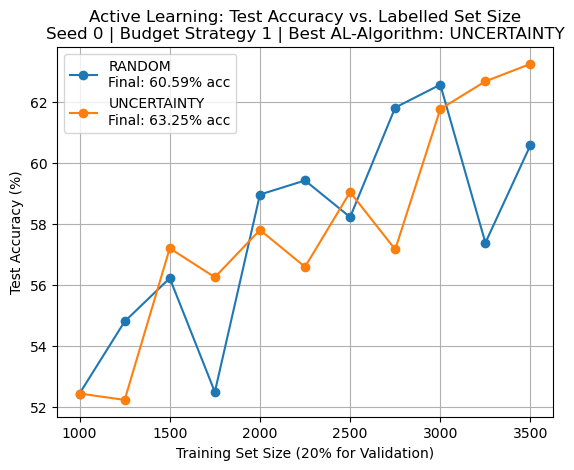


[SEED 0 (1/2)) | BUDGET STRATEGY 2 (2/2)]
Initial size: 4000 → Final size: 9000 | Query size: 500 | AL Iterations: 10

[SEED 0 (1/2) | BUDGET STRATEGY 2 (2/2) | AL: RANDOM (1/2)]
  Iteration 0/10 - Samples: 4000 (20% val), Test: 64.31% acc, Time: 18.52s, Training: 14.83s, AL: N/A
  Iteration 1/10 - Samples: 4500 (20% val), Test: 63.19% acc, Time: 20.95s, Training: 17.39s, AL: 0.00s
  Iteration 2/10 - Samples: 5000 (20% val), Test: 65.77% acc, Time: 22.55s, Training: 18.74s, AL: 0.00s
  Iteration 3/10 - Samples: 5500 (20% val), Test: 67.77% acc, Time: 24.16s, Training: 20.51s, AL: 0.00s
  Iteration 4/10 - Samples: 6000 (20% val), Test: 67.93% acc, Time: 26.32s, Training: 22.48s, AL: 0.00s
  Iteration 5/10 - Samples: 6500 (20% val), Test: 64.71% acc, Time: 27.96s, Training: 24.26s, AL: 0.00s
  Iteration 6/10 - Samples: 7000 (20% val), Test: 66.89% acc, Time: 29.64s, Training: 25.88s, AL: 0.00s
  Iteration 7/10 - Samples: 7500 (20% val), Test: 69.26% acc, Time: 32.92s, Training: 28.87s, 

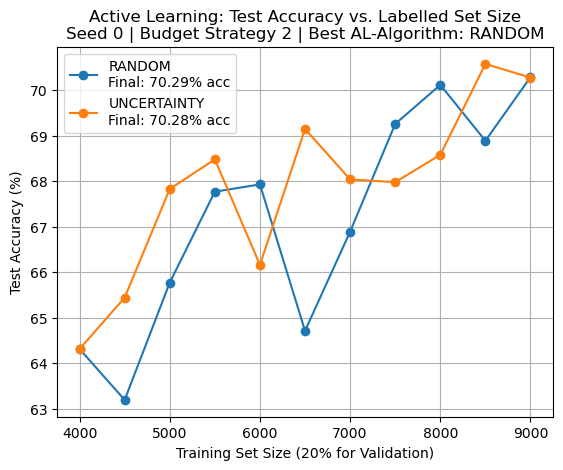



[SEED 1 (2/2)]
Imbalanced dataset disabled, skipping...

[SEED 1 (2/2) | TRAINING FULL DATASET BASELINE]
Baseline Complete - Test: 80.34% acc, Total time: 3m 18.74s

[SEED 1 (2/2)) | BUDGET STRATEGY 1 (1/2)]
Initial size: 1000 → Final size: 3500 | Query size: 250 | AL Iterations: 10

[SEED 1 (2/2) | BUDGET STRATEGY 1 (1/2) | AL: RANDOM (1/2)]
  Iteration 0/10 - Samples: 1000 (20% val), Test: 51.68% acc, Time: 8.38s, Training: 4.45s, AL: N/A
  Iteration 1/10 - Samples: 1250 (20% val), Test: 55.97% acc, Time: 8.56s, Training: 4.75s, AL: 0.00s
  Iteration 2/10 - Samples: 1500 (20% val), Test: 56.96% acc, Time: 9.62s, Training: 5.75s, AL: 0.00s
  Iteration 3/10 - Samples: 1750 (20% val), Test: 57.93% acc, Time: 10.51s, Training: 6.68s, AL: 0.00s
  Iteration 4/10 - Samples: 2000 (20% val), Test: 56.83% acc, Time: 11.25s, Training: 7.59s, AL: 0.00s
  Iteration 5/10 - Samples: 2250 (20% val), Test: 59.29% acc, Time: 12.32s, Training: 8.72s, AL: 0.00s
  Iteration 6/10 - Samples: 2500 (20% va

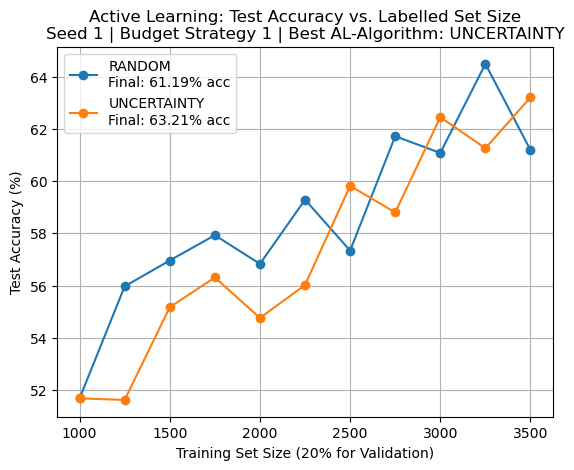


[SEED 1 (2/2)) | BUDGET STRATEGY 2 (2/2)]
Initial size: 4000 → Final size: 9000 | Query size: 500 | AL Iterations: 10

[SEED 1 (2/2) | BUDGET STRATEGY 2 (2/2) | AL: RANDOM (1/2)]
  Iteration 0/10 - Samples: 4000 (20% val), Test: 65.28% acc, Time: 19.73s, Training: 15.81s, AL: N/A
  Iteration 1/10 - Samples: 4500 (20% val), Test: 65.91% acc, Time: 21.37s, Training: 17.57s, AL: 0.00s
  Iteration 2/10 - Samples: 5000 (20% val), Test: 66.67% acc, Time: 22.35s, Training: 18.59s, AL: 0.00s
  Iteration 3/10 - Samples: 5500 (20% val), Test: 67.83% acc, Time: 23.73s, Training: 19.98s, AL: 0.00s
  Iteration 4/10 - Samples: 6000 (20% val), Test: 67.17% acc, Time: 25.63s, Training: 21.75s, AL: 0.00s
  Iteration 5/10 - Samples: 6500 (20% val), Test: 68.23% acc, Time: 27.81s, Training: 23.94s, AL: 0.00s
  Iteration 6/10 - Samples: 7000 (20% val), Test: 69.78% acc, Time: 29.99s, Training: 26.01s, AL: 0.00s
  Iteration 7/10 - Samples: 7500 (20% val), Test: 68.86% acc, Time: 32.17s, Training: 28.24s, 

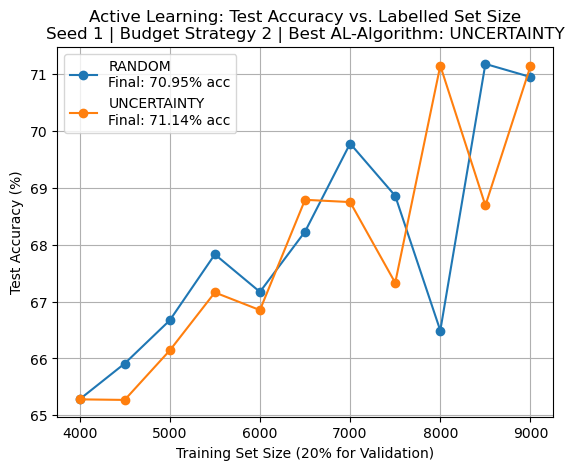

SIMULATION COMPLETE
Total Runtime: 44m 1.66s

Plotting average AL-algorithm performances for each budget strategy across all seeds...
    Random:
        Mean Final Accuracy: 60.89%
        95% CI: [58.19%, 63.59%]
    Uncertainty:
        Mean Final Accuracy: 63.23%
        95% CI: [63.05%, 63.41%]


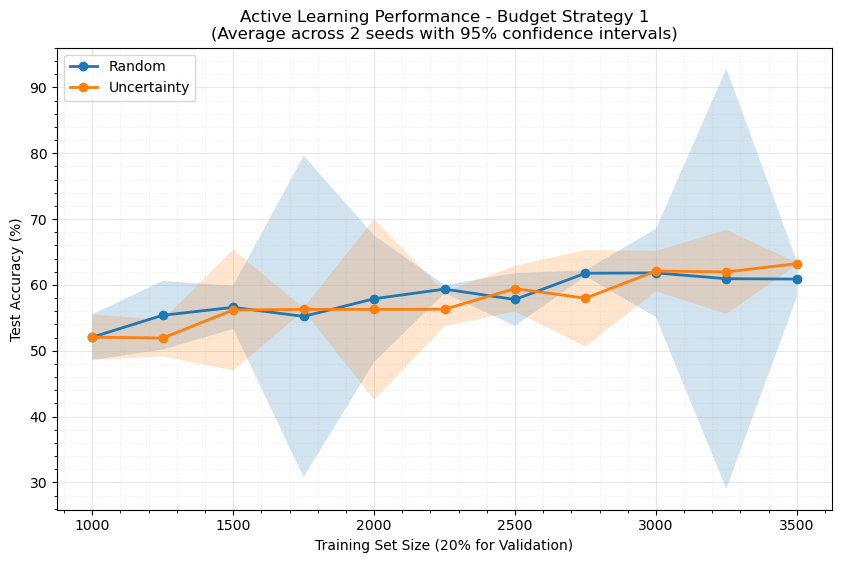

    Random:
        Mean Final Accuracy: 70.62%
        95% CI: [67.66%, 73.58%]
    Uncertainty:
        Mean Final Accuracy: 70.71%
        95% CI: [66.85%, 74.57%]


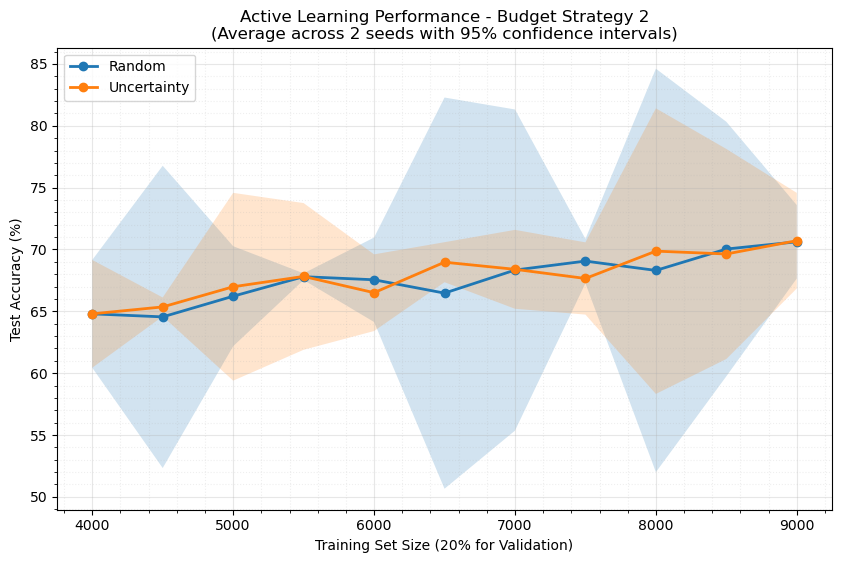


Simulation results saved to 
./run_results/cifar-10_resnet-18_ptw1_tvr80_ep8_bs32_sds0-1_bl1_algo-ran-unc_bsr1-2_bis1000-4000_bqs250-500_bni10-10


In [7]:
## Print Configuration Summary ##
print(f"\nConfig summary:")
print(f"- Save results: {save_results}")
print(f"- Device: {device} | Dataset: {dataset_name}")
print(f"- Model: {model_name} | Pretrained: {pretrained_weights} | Train/Val Ratio: {TRAIN_VAL_RATIO} | Epochs: {EPOCHS} | Batch Size: {BATCH_SIZE}")
print(f"- Seeds to run: {seeds}")
print(f"- Run full dataset baseline per seed: {train_full_dataset_baseline}")
print(f"- Budget strategies per seed: {budget_strategies}")
print(f"- AL-algorithms per budget strategy: {al_algorithms}")

print("\nBeginning AL Simulation...")


## Simulation Loop ##
simulation_time = time.time() # Initialize timer

# Run the active learning evaluation loop for each seed
for seed_idx, seed in enumerate(seeds):
    seed_time = time.time()
    simulation_data["results"][f"seed_{seed}"] = {}
    print(f"\n\n[SEED {seed} ({seed_idx+1}/{num_seeds})]")
    
    # Set random seed and generator used for data loaders
    initial_generator = set_global_seed(seed)

    # Create imbalanced CIFAR-10 dataset
    if imbalanced_dataset and dataset_name == "CIFAR-10":
        # Add small random variations to make it more realistic
        keep_ratios = {k: min(1.0, max(0.05, v + np.random.normal(0, 0.05))) 
                for k, v in base_ratios.items()}
        
        train_val_dataset = create_imbalanced_cifar10(OG_train_val_dataset, keep_ratios)
        print("Imbalanced CIFAR-10 training / validation created, len(train_val_dataset):", len(train_val_dataset))
        print(f"Test dataset is unchanged, len(test_dataset): {len(test_dataset)}")
    else:
        print("Imbalanced dataset disabled, skipping...")

    # Split into training and validation sets
    train_size = int(TRAIN_VAL_RATIO * len(train_val_dataset))
    val_size = len(train_val_dataset) - train_size

    # Split the dataset into training and validation
    train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size], generator=initial_generator)

    # (If enabled) Train the model with entire dataset labelled to establish maximum performance baseline
    if train_full_dataset_baseline:
        print(f"\n[SEED {seed} ({seed_idx+1}/{num_seeds}) | TRAINING FULL DATASET BASELINE]")

        full_dataset_baseline_time = time.time()

        test_accuracy = full_training_set_baseline(
            device=device, 
            dataset_name=dataset_name,
            model_name=model_name, 
            pretrained_weights=pretrained_weights, 
            epochs=EPOCHS, 
            batch_size=BATCH_SIZE, 
            train_dataset=train_dataset, 
            val_dataset=val_dataset, 
            test_dataset=test_dataset, 
            generator=initial_generator)

        full_dataset_baseline_time = time.time() - full_dataset_baseline_time

        simulation_data["results"][f"seed_{seed}"]["full_dataset_baseline"] = test_accuracy
        simulation_data["runtimes"]["full_dataset_baselines"][f"seed_{seed}_full_dataset_baseline"] = full_dataset_baseline_time

        print(f"Baseline Complete - Test: {test_accuracy:.2f}% acc, Total time: {format_time(full_dataset_baseline_time)}")
    else:
        simulation_data["results"][f"seed_{seed}"]["full_dataset_baseline"] = None
        simulation_data["runtimes"]["full_dataset_baselines"][f"seed_{seed}_full_dataset_baseline"] = None
        print("Full dataset baseline disabled, skipping...")


    # For each budget strategy, train, evaluate, visualize and compare all AL strategies
    for strategy_idx, strategy in enumerate(budget_strategies):
        budget_strategy_time = time.time()
        simulation_data["results"][f"seed_{seed}"][f"budget_strategy_{strategy}"] = {}

        budget_initial_size = budget_initial_sizes[strategy_idx]
        budget_query_size = budget_query_sizes[strategy_idx]
        budget_al_iterations = budget_total_al_iterations[strategy_idx]
        budget_final_size = budget_final_sizes[strategy_idx]

        print(f"\n[SEED {seed} ({seed_idx+1}/{num_seeds})) | BUDGET STRATEGY {strategy} ({strategy_idx+1}/{num_strategies})]")
        print(f"Initial size: {budget_initial_size} → Final size: {budget_final_size} | Query size: {budget_query_size} | AL Iterations: {budget_al_iterations}")
        
        # Debug lists for initial test accuracy, should be the same for all AL algorithms since no AL happens in the first (0'th) iteration, only training on the same initial labelled set
        debug_initial_test_accuracy = []

        for al_algorithm_idx, al_algorithm in enumerate(al_algorithms):
            simulation_data["results"][f"seed_{seed}"][f"budget_strategy_{strategy}"][al_algorithm] = {}
            
            print(f"\n[SEED {seed} ({seed_idx+1}/{num_seeds}) | BUDGET STRATEGY {strategy} ({strategy_idx+1}/{num_strategies}) | AL: {al_algorithm.upper()} ({al_algorithm_idx+1}/{num_al_algorithms})]")
            
            # Run active learning loop, return training set sizes and corresponding test accuracies
            train_val_set_sizes, test_accuracies, training_time_total, al_time_total = active_learning_loop(
                device=device, 
                dataset_name=dataset_name,
                model_name=model_name,
                pretrained_weights=pretrained_weights,
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                train_val_ratio=TRAIN_VAL_RATIO,  
                train_val_dataset=train_val_dataset,
                test_dataset=test_dataset,
                generator=initial_generator,
                budget_initial_size=budget_initial_size,
                budget_query_size=budget_query_size,
                budget_al_iterations=budget_al_iterations,
                al_algorithm=al_algorithm
            )

            # Store results
            simulation_data["results"][f"seed_{seed}"][f"budget_strategy_{strategy}"][al_algorithm]["train_val_set_sizes"] = train_val_set_sizes
            simulation_data["results"][f"seed_{seed}"][f"budget_strategy_{strategy}"][al_algorithm]["test_accuracies"] = test_accuracies

            # Store training and AL algorithm runtimes
            simulation_data["runtimes"]["training_and_al_algorithms"][f"seed_{seed}_budget_{strategy}_{al_algorithm}"]["training"] = training_time_total
            simulation_data["runtimes"]["training_and_al_algorithms"][f"seed_{seed}_budget_{strategy}_{al_algorithm}"]["al"] = al_time_total

            print(f"{al_algorithm.upper()} complete - Test: {test_accuracies[-1]:.2f}% acc, Total training time: {format_time(training_time_total)}, Total AL time: {format_time(al_time_total)}")

            # Debug: Store initial test accuracy for comparison
            debug_initial_test_accuracy.append(test_accuracies[0])
            if len(debug_initial_test_accuracy) > 1:
                assert abs(debug_initial_test_accuracy[-1] - debug_initial_test_accuracy[-2]) < 1e-6, "Initial test accuracy should be the same for all AL algorithms, as no AL happens in the first iteration and model is trained on the same initial labelled set."


        budget_strategy_time = time.time() - budget_strategy_time
        simulation_data["runtimes"]["budget_strategies"][f"seed_{seed}_budget_{strategy}"] = budget_strategy_time

        strategy_best_algorithm = None
        strategy_best_accuracy = 0

        print(f"\n[SEED {seed} ({seed_idx+1}/{num_seeds})) | BUDGET STRATEGY {strategy} ({strategy_idx+1}/{num_strategies}) | COMPLETED]")
        print(f"Total Runtime: {format_time(budget_strategy_time)}, Summary:")
        for al_algorithm_idx, al_algorithm in enumerate(al_algorithms):
            test_accuracies = simulation_data["results"][f"seed_{seed}"][f"budget_strategy_{strategy}"][al_algorithm]["test_accuracies"]
            training_time_total = simulation_data["runtimes"]["training_and_al_algorithms"][f"seed_{seed}_budget_{strategy}_{al_algorithm}"]["training"]
            al_time_total = simulation_data["runtimes"]["training_and_al_algorithms"][f"seed_{seed}_budget_{strategy}_{al_algorithm}"]["al"]

            if test_accuracies[-1] > strategy_best_accuracy or strategy_best_algorithm is None:
                strategy_best_algorithm = al_algorithm
                strategy_best_accuracy = test_accuracies[-1]

            print(f"{al_algorithm_idx+1}. {al_algorithm.upper()} summary - Test: {test_accuracies[-1]:.2f}% acc, Total training time: {format_time(training_time_total)}, Total AL time: {format_time(al_time_total)}")
        print(f"Best AL-Algorithm for Budget Strategy {strategy}: {strategy_best_algorithm.upper()}, Test Accuracy: {strategy_best_accuracy:.2f}%")

        plt.figure()
        for al_algorithm in al_algorithms:
            train_val_set_size = simulation_data["results"][f"seed_{seed}"][f"budget_strategy_{strategy}"][al_algorithm]["train_val_set_sizes"]
            test_accuracies = simulation_data["results"][f"seed_{seed}"][f"budget_strategy_{strategy}"][al_algorithm]["test_accuracies"]
            plt.plot(train_val_set_sizes, test_accuracies, label=f"{al_algorithm.upper()}\nFinal: {test_accuracies[-1]:.2f}% acc",marker='o')
        plt.xlabel(f'Training Set Size ({(1 - TRAIN_VAL_RATIO) * 100:.0f}% for Validation)')
        plt.ylabel('Test Accuracy (%)')
        plt.title(f'Active Learning: Test Accuracy vs. Labelled Set Size\nSeed {seed} | Budget Strategy {strategy} | Best AL-Algorithm: {strategy_best_algorithm.upper()}')
        plt.grid(True)
        plt.legend()
        plt.show()
    
    seed_time = time.time() - seed_time
    simulation_data["runtimes"]["seeds"][f"seed_{seed}"] = seed_time

simulation_time = time.time() - simulation_time
simulation_data["runtimes"]["simulation"] = simulation_time

# Plot average results for all AL algorithms for each budget strategy over all seeds
print("SIMULATION COMPLETE")
print(f"Total Runtime: {format_time(simulation_time)}")
if len(seeds) > 1:
    print("\nPlotting average AL-algorithm performances for each budget strategy across all seeds...")
    for strategy in budget_strategies:
        fig = plot_al_performance_across_seeds(
            simulation_data,
            strategy,
            al_algorithms
        )
        plt.show()
else:
    print("\nSkipping average AL-algorithm performance plots - Only one seed was run.")


# Save the results to a JSON file if enabled and the file does not already exist
if save_results:
    if not os.path.exists(file_path): # Check if file already exists
        # Save the dictionary as a JSON file
        with open(file_path, "w") as file:
            json.dump(simulation_data, file, indent=4)
        print(f"\nSimulation results saved to \n{file_path}")
else:
    print("\nSAVING DISABLED - Results not saved to file. Set save_results to True to save results.")


Upon completion of the simulation, the config + various runtimes + various results are saved as a .json file (if enabled), and can be reloaded, visualized and analyzed in one of the plot scripts.